In [1]:
# !pip install tensorflow-gpu==2.0.0-alpha0
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

# from tensorflow.keras.layers import Bidirectional, CuDNNLSTM, Dense


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [15]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "stock-prediction_BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [16]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [17]:
df = df.sort_values('Date')

In [18]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [19]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

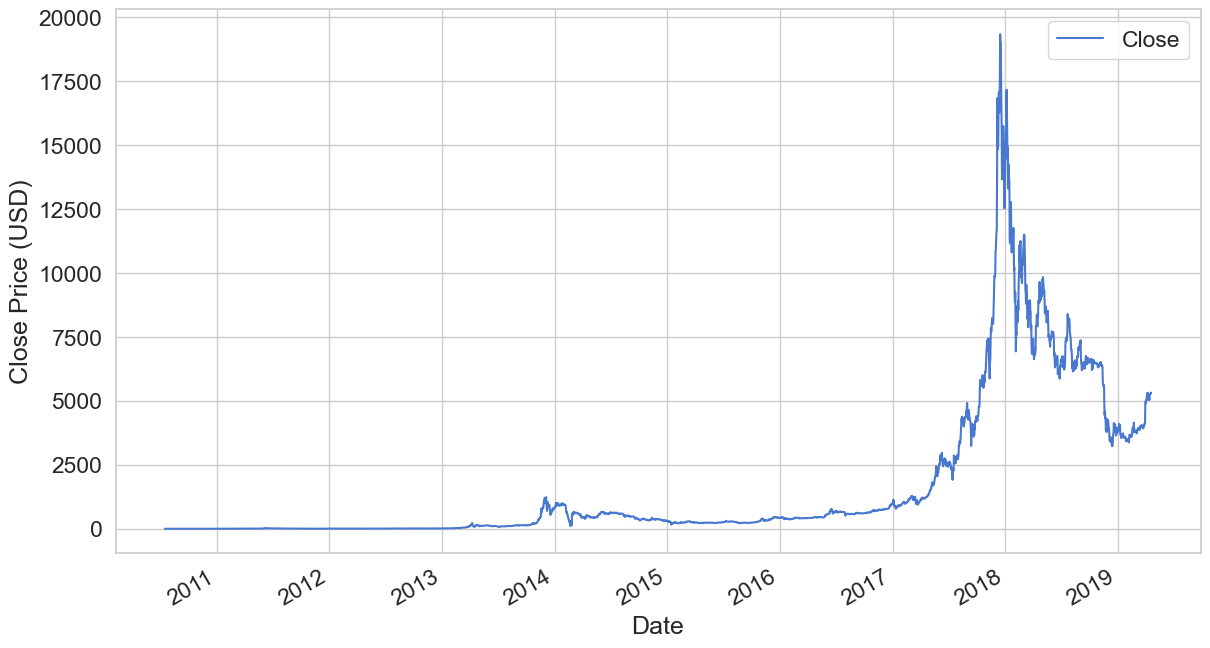

In [20]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [21]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [22]:
scaled_close.shape

(3201, 1)

In [23]:
np.isnan(scaled_close).any()

False

In [24]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [25]:
scaled_close = scaled_close.reshape(-1, 1)

In [26]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [27]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [28]:
X_train.shape

(2945, 99, 1)

In [29]:
X_test.shape

(156, 99, 1)

# Model

In [30]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 99, 198)           79992     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 198)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 99, 396)           628848    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 198)               392832    
 onal)                                                           
                                                        

# Training

In [31]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [32]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 101s 2s/step - loss: 0.0013 - val_loss: 0.0080
Epoch 2/50
42/42 [==============================] - 87s 2s/step - loss: 0.0054 - val_loss: 0.0074
Epoch 3/50
42/42 [==============================] - 92s 2s/step - loss: 0.0134 - val_loss: 0.0091
Epoch 4/50
42/42 [==============================] - 82s 2s/step - loss: 0.0071 - val_loss: 0.0033
Epoch 5/50
42/42 [==============================] - 95s 2s/step - loss: 0.0114 - val_loss: 0.0316
Epoch 6/50
42/42 [==============================] - 98s 2s/step - loss: 0.0027 - val_loss: 0.0216
Epoch 7/50
42/42 [==============================] - 100s 2s/step - loss: 6.8688e-04 - val_loss: 0.0243
Epoch 8/50
42/42 [==============================] - 93s 2s/step - loss: 0.0012 - val_loss: 0.0059
Epoch 9/50
42/42 [==============================] - 96s 2s/step - loss: 0.0100 - val_loss: 0.0476
Epoch 10/50
42/42 [==============================] - 98s 2s/step - loss: 0.0073 - val_loss: 0.0072
Epoch 11/50
4

In [33]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 2s 328ms/step - loss: 0.0016


0.001613136613741517

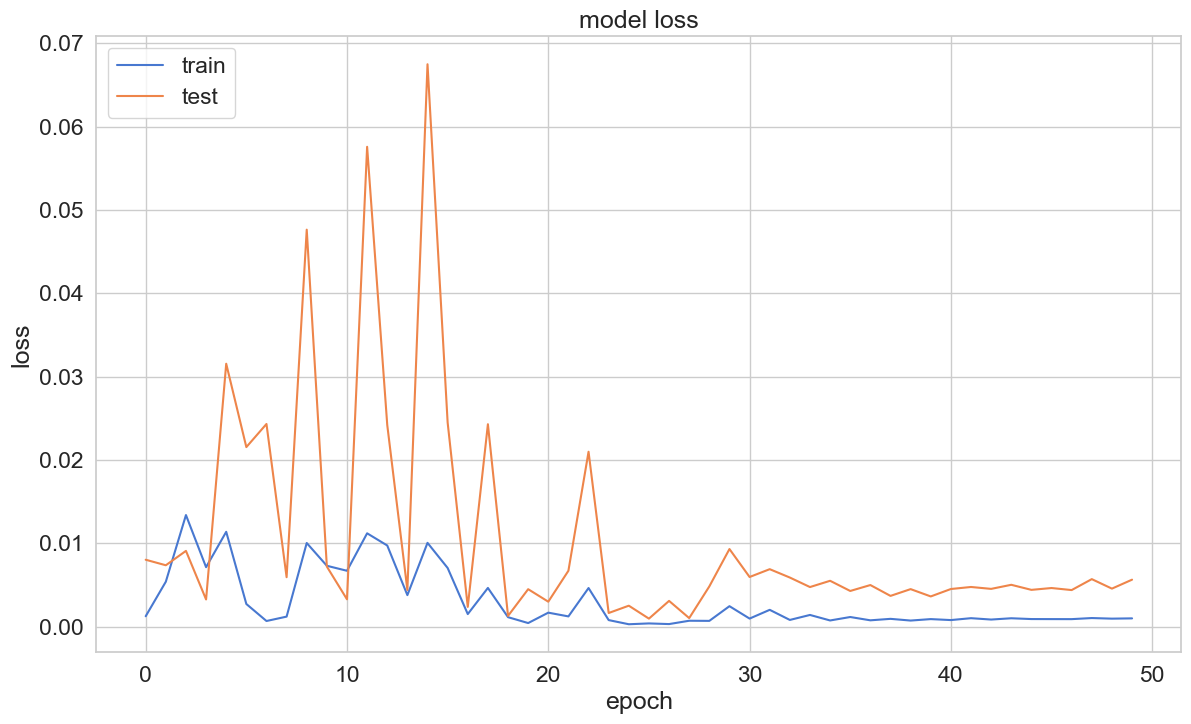

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

5/5 [==============================] - 10s 269ms/step


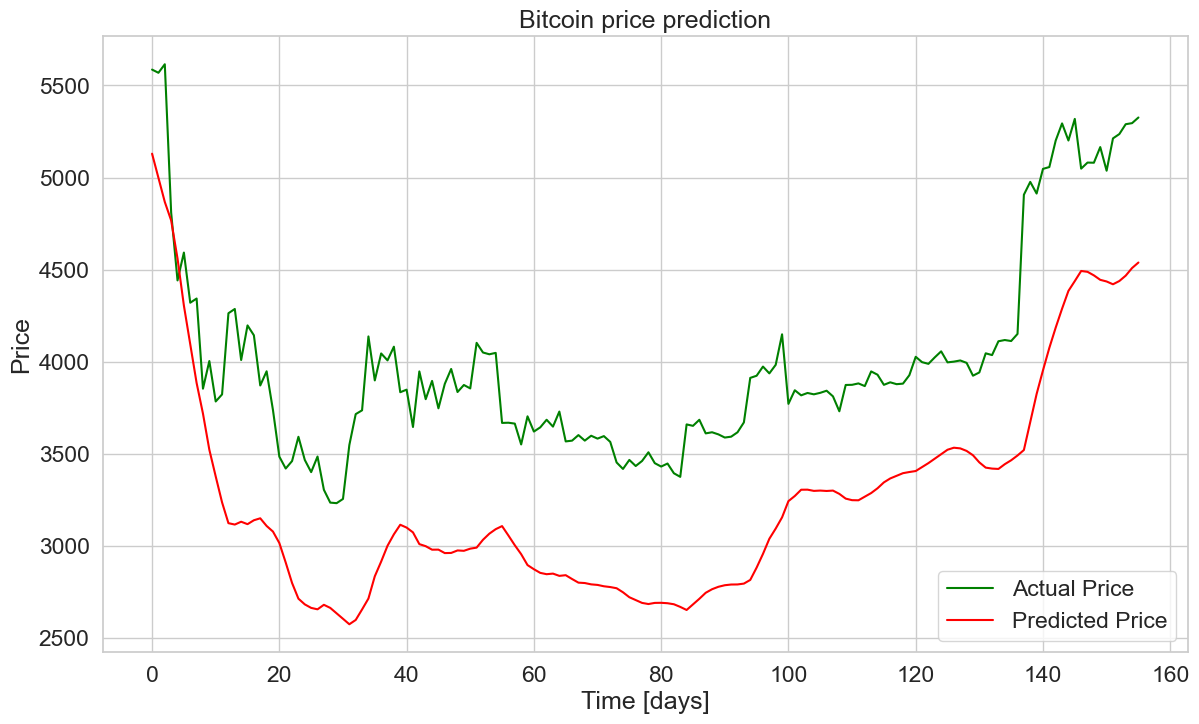

In [35]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();